In [ ]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [ ]:

vgg = models.vgg19(pretrained=True).features


for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [ ]:

content = load_image('/content/bo.jpg').to(device)

style = load_image('/content/style_image.jpg', shape=content.shape[-2:]).to(device)

FileNotFoundError: ignored

In [ ]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

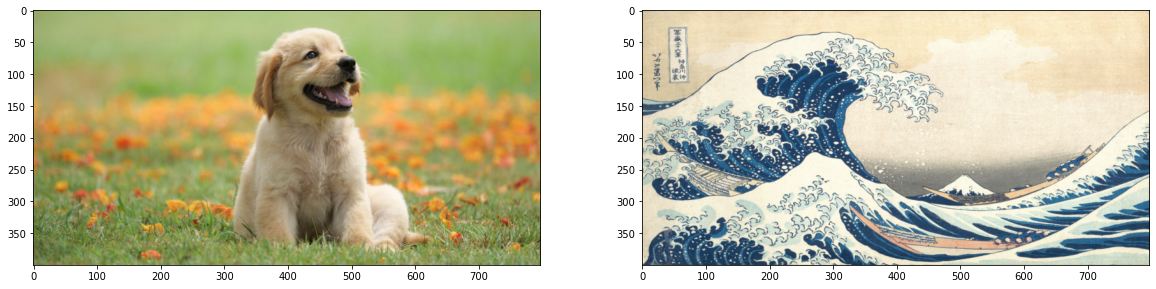

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [ ]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2', #for getting the representation of the content
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [ ]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """

    b, d, h, w = tensor.size()

    tensor = tensor.view(b * d, h * w)

    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [ ]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [ ]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1 
style_weight = 1e6

Total loss:  95065856.0


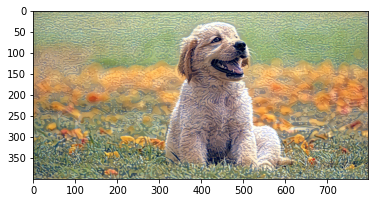

Total loss:  38776756.0


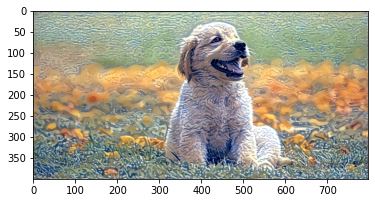

Total loss:  25362386.0


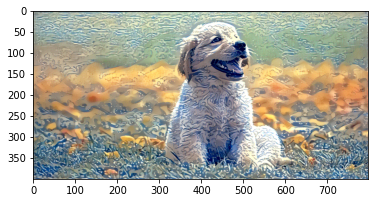

Total loss:  18215824.0


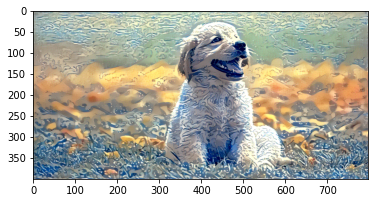

Total loss:  13064469.0


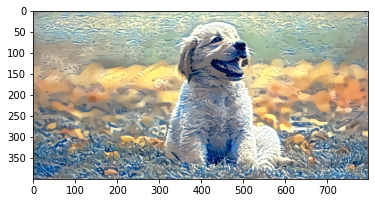

Total loss:  9188536.0


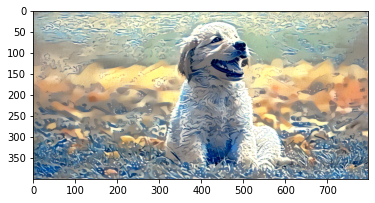

Total loss:  6306242.5


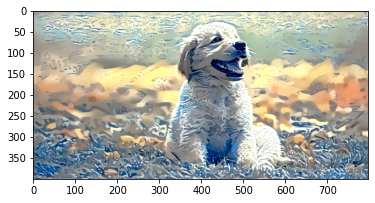

Total loss:  4242818.5


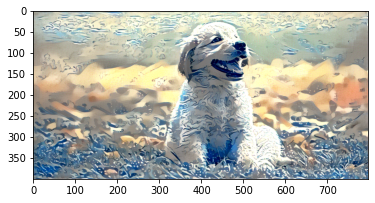

Total loss:  2826789.5


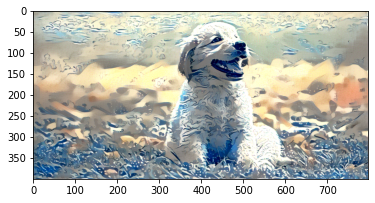

Total loss:  1906993.25


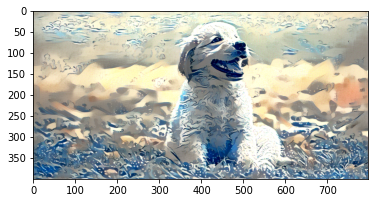

Total loss:  1334642.875


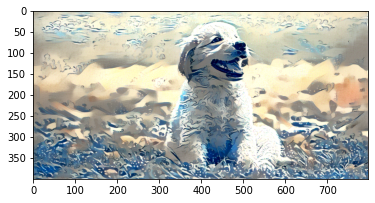

Total loss:  977183.0


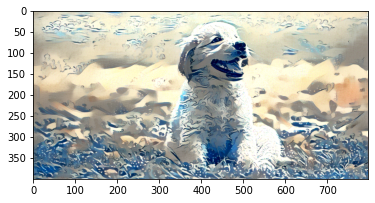

Total loss:  744268.4375


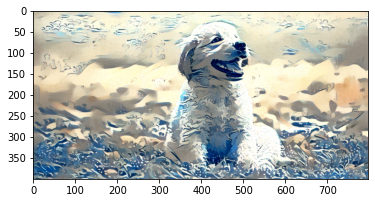

Total loss:  585086.0625


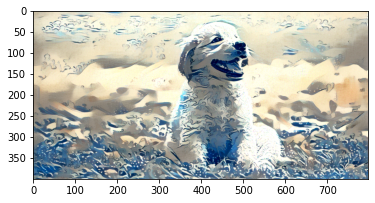

Total loss:  471000.03125


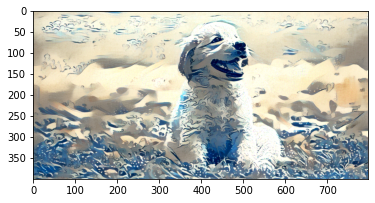

Total loss:  385840.125


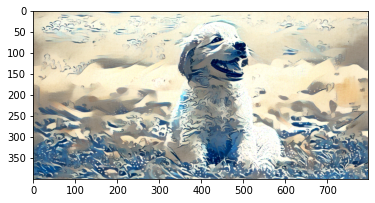

Total loss:  320333.125


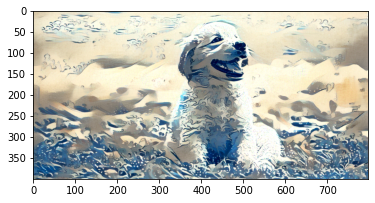

Total loss:  268410.25


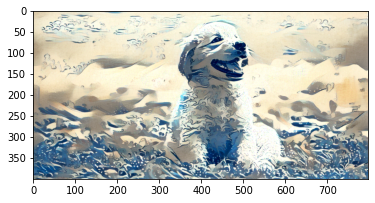

Total loss:  227077.078125


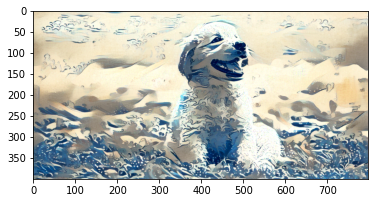

Total loss:  194362.125


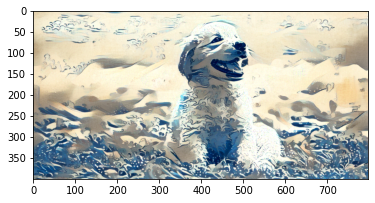

Total loss:  168659.390625


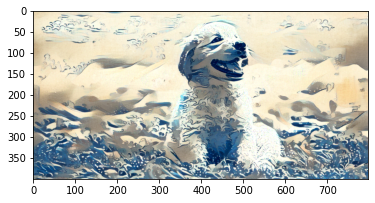

Total loss:  148111.796875


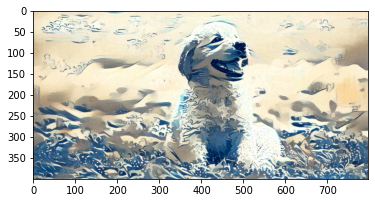

Total loss:  131718.65625


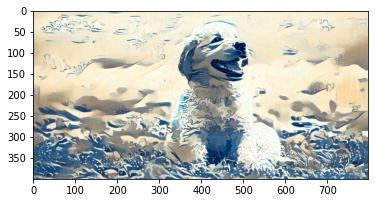

Total loss:  118759.84375


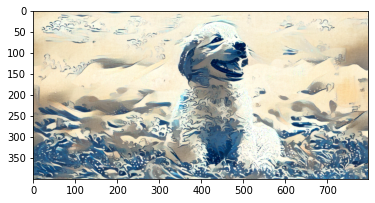

Total loss:  108234.9921875


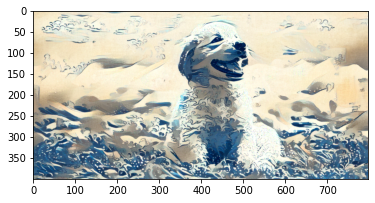

In [ ]:
show_every = 400

optimizer = optim.Adam([target], lr=0.003)
steps = 10000

for ii in range(1, steps+1):

    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

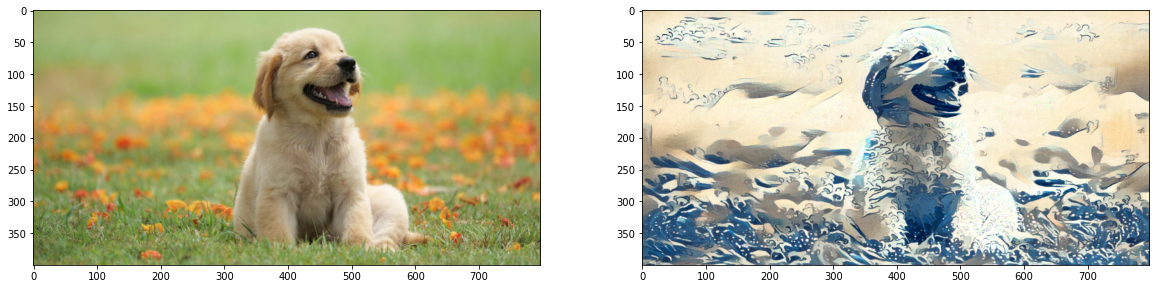

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))